# 기초 모델링

In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optm

In [220]:
torch.manual_seed(1)

In [221]:
X_train = torch.FloatTensor([[1],[2],[3]])
y_train = torch.FloatTensor([[2],[4],[6]])

## to(device)

In [222]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [223]:
# 랜덤 고정
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## TensorDataset

Dataset 을 묶는 텐서를 형성한다.

Each sample will be retrieved by indexing tensors along the first dimension.

In [224]:
from torch.utils.data import TensorDataset 
dataset = TensorDataset(X_train, y_train)
# Tensor Dateset 은 기본적으로 텐서를 입력으로 받는다 (즉 np,pd 같은 데이터형태를 torch.Tensor 로 바꾸어주어야한다.)
# Tensor 데이터셋 선언 (x,y 엮어서 하나로 만들어준다.)

In [225]:
# dir(dataset) 을 해보면 메서드/attribute 들이 형성된것을 볼 수 있다.

## DataLoader

간단하게 생각하면 DataLoader 객체는 학습에 쓰일 데이터 전체를 보관했다가, train 함수가 batch 하나를 요구하면 batch size 개수만큼 데이터를 꺼내서 준다고 보면 된다.

실제로 [batch size, num]처럼 미리 잘라놓는 것은 아니고, 내부적으로 Iterator에 포함된 Index가 존재한다. train() 함수가 데이터를 요구하면 사전에 저장된 batch size만큼 return하는 형태이다.


- batch_size : 2의 배수를 넣는게 cpu/gpu 구조상 더 효율적이다.
- shuffle : 셔플하지 않으면 데이터셋의 순서에 익숙해져서 학습이 비효율적이 될 수 있다. 그래서 True 를 권장 ( 사람도 같은 문제지를 계속 풀면 어느순간 문제의 순서에 익숙해질 수 있다. (즉 데이터가 학습되는 순서에 익숙해져서 학습될수도..)
- drop last : drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.


In [230]:
x_train  =  torch.FloatTensor([[73,  80,  75], 
                               [93,  88,  93], 
                               [89,  91,  90], 
                               [96,  98,  100],   
                               [73,  66,  70]])  
y_train  =  torch.FloatTensor([[152],  [185],  [180],  [196],  [142]])

In [231]:
dataset = TensorDataset(x_train, y_train) # 텐서데이터셋 형태로 만든다 (X,y 묶어서 하나로 만들어준다.)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
model = nn.Linear(3,1) # 모델설정
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)  # 옵티마이저 설정

In [232]:
nb_epochs = 3
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader): # batch index , sample( tuple 상태인 x,y ) 를 도출
        x_train, y_train = samples # x,y 나누기
        y_pred = model(x_train)
        cost = F.mse_loss(y_pred, y_train)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format( epoch, nb_epochs, batch_idx+1, len(dataloader), cost.item()))


Epoch    0/3 Batch 1/3 Cost: 6299.984863
Epoch    0/3 Batch 2/3 Cost: 1424.307251
Epoch    0/3 Batch 3/3 Cost: 352.370911
Epoch    1/3 Batch 1/3 Cost: 158.049103
Epoch    1/3 Batch 2/3 Cost: 99.115723
Epoch    1/3 Batch 3/3 Cost: 25.065502
Epoch    2/3 Batch 1/3 Cost: 13.175940
Epoch    2/3 Batch 2/3 Cost: 0.309332
Epoch    2/3 Batch 3/3 Cost: 0.005093
Epoch    3/3 Batch 1/3 Cost: 3.167757
Epoch    3/3 Batch 2/3 Cost: 1.937045
Epoch    3/3 Batch 3/3 Cost: 1.109085


## Custum Dataset

전처리 과정이 같은 데이터들에 대해서 계속 전처리 과정을 써주는것은 매우 있다. 전처리과정 ~ tensor 형태의 데이터셋 변환 까지 합쳐진 과정을 한번에 수행하는 class 를 정의함으로서 훨씬 효율적으로 작업이 가능하다.

nn.Module을 상속하는 Custom Model처럼, Custom DataSet은 torch.utils.data.Dataset를 상속해야 한다. 또한 override해야 하는 것은 다음 두 가지다.

__len__(self): dataset의 전체 개수를 알려준다.

__getitem__(self, idx): parameter로 idx를 넘겨주면 idx번째의 데이터를 x,y 형태로 반환한다.


In [233]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset): 
    def __init__(self):   #데이터셋의 전처리를 해주는 부분
        self.x_data = X_train
        self.y_data = y_train
        
    def __len__(self):   #데이터셋 길이(총 샘플의 수) 를 도출하는 매직 메서드를 정의한다.
        return len(self.x_data)

    def __getitem__(self, idx):   # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴(#데이터셋에서 특정 1개의 샘플을 가져오는 함수)하는 메서드를 정의한다.
        x = torch.FloatTensor(self.x_data[idx]) # dataset[i]을 했을 때 i번째 샘플을 가져오도록 하는 인덱싱을 위한 get_item
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

dataset = CustomDataset() # 데이터셋을 원래 형태에서 전처리->pytorch 데이터 형태로 바로 변환이 가능하다.
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## 가중치와 편향의 초기화

In [234]:
W = torch.zeros(1,requires_grad=True) ; print(W)
# 가중치를 0 으로 초기화한다. (zeros)
# 학습을 통해 값이 변경되는 변수임을 명시한다. (requires_grad = True 임을 통해서)
# size 가 1 인 zeros 의 tensor 를 형성하자.

tensor([0.], requires_grad=True)


In [235]:
b = torch.zeros(1,requires_grad=True) ; print(b)
# 편향(b) 역시 0으로 초기화하고, 학습을 통해서 변하는 변수임을 명시해주자.
# size 가 1 인 zero 의 tensor 를 형성하자.

tensor([0.], requires_grad=True)


## y_pred 모델 형성

In [236]:
# linear regression 이므로 y_pred 모델은 아래와 같다.
y_pred = X_train*W + b ; print(y_pred) 
# 처음의 값은 아직 gradient method 를 쓰지 않아서 초기화된 W,b 를 계산한 0,0,0 임을 볼 수 있다.

tensor([[0.],
        [0.],
        [0.]], grad_fn=<AddBackward0>)


## cost 정의

In [237]:
cost = torch.mean((y_pred - y_train)**2)
# cost 를 정해준다. 이 떄의 cost 는 mse
# 어짜피 계산하는 부분이므로 굳이 변한다는(required_grad = True) 는 쓰지 않는다.

## optimizer 
- 맨 앞 인자는 UPDATE 의 대상을 LIST 형태로 받는다.
- lr : 학습율

In [238]:
optimizer = torch.optim.SGD([W,b] ,lr=0.01)

## optimizer.zero_grad()

기울기 초기화

In [239]:
optimizer.zero_grad()
# optimizer.zero_grad()를 실행함으로서 미분을 통해 얻은 기울기를 0으로 초기화한다.
# 파이토치는 기울기를 계속 누적(전에 구한값이 초기화 되지 않고 계속 남아있음) 시키려고 하기 떄문에 초기화시키는 작업이 꼭 필요하다.
# 기울기를 초기화 해야함 새로운 가중치 편향에 대하여 새로운 기울기를 구할 수 있다.

## cost.backward()

W,b 에 대한 기울기 계산

In [240]:
cost.backward()
# cost.backward() 를 호출하면 가중치 W 와 편향 b 에 대한 기울기가 계산된다.

## optimizer.step()

In [241]:
optimizer.step()
# 그 다음에는 우리가 정한 경사하강법 optimizer 의 step 함수를 호출하여, 인수로 들어갔던 W 와 b 에서 리턴되는 변수들의 기울기에 학습률 0.01 을 곱하여 뺴줌으로서 업데이트된다.
# W 와 b를 업데이트

# Why?

## optimizer.zero_grad() 가 필요한 이유

In [242]:
# 파이토치는 미분을 통해 얻은 기울기를 이전에 기울기 값에 누적시키는 특징이 있다.

In [243]:
W = torch.tensor(2.0,requires_grad=True)

n_epochs = 20
for epoch in range(n_epochs + 1):
    z = 2*W
    z.backward()
    print('수식을 w 로 미분한 값 : {}'.format(W.grad)) 

수식을 w 로 미분한 값 : 2.0
수식을 w 로 미분한 값 : 4.0
수식을 w 로 미분한 값 : 6.0
수식을 w 로 미분한 값 : 8.0
수식을 w 로 미분한 값 : 10.0
수식을 w 로 미분한 값 : 12.0
수식을 w 로 미분한 값 : 14.0
수식을 w 로 미분한 값 : 16.0
수식을 w 로 미분한 값 : 18.0
수식을 w 로 미분한 값 : 20.0
수식을 w 로 미분한 값 : 22.0
수식을 w 로 미분한 값 : 24.0
수식을 w 로 미분한 값 : 26.0
수식을 w 로 미분한 값 : 28.0
수식을 w 로 미분한 값 : 30.0
수식을 w 로 미분한 값 : 32.0
수식을 w 로 미분한 값 : 34.0
수식을 w 로 미분한 값 : 36.0
수식을 w 로 미분한 값 : 38.0
수식을 w 로 미분한 값 : 40.0
수식을 w 로 미분한 값 : 42.0


In [244]:
# 계속해서 미분값인 2가 누적되고 있다! 
# 그렇기 떄문에 중간중간 optimizer.zero_grad() 를 통해서 미분값을 계속 0으로 초기화 시켜주어야한다.

# Simple Linear Regression

In [245]:
# 데이터
X_train = torch.FloatTensor([[1],[2],[3]])
y_train = torch.FloatTensor([[2],[4],[6]])

## low level
- low level 은 y_pred / W,b 초기화 방법 / cost 의 정의 들을 사용자가 직접 정의한다.

In [246]:
# 모델 초기화
W = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = torch.optim.SGD([W,b],lr=0.05)

# epochs 설정
n_epochs = 2000

In [247]:
for epoch in range(n_epochs +1 ) :
    # y_hat 계산
    y_pred = X_train * W + b
    # cost 계산
    cost = torch.mean((y_pred-y_train)**2)
    # cost 를 토대로 update
    optimizer.zero_grad() # gradient 를 0 으로 초기화
    cost.backward() # W,b 에 대한 gradient 계산
    optimizer.step() # update W,b

    # 100번마다 기록 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
            epoch, n_epochs, W.item(), b.item(), cost.item()))

Epoch    0/2000 W: 0.933, b: 0.400 Cost: 18.666666
Epoch  100/2000 W: 1.904, b: 0.217 Cost: 0.006942
Epoch  200/2000 W: 1.971, b: 0.065 Cost: 0.000618
Epoch  300/2000 W: 1.991, b: 0.019 Cost: 0.000055
Epoch  400/2000 W: 1.997, b: 0.006 Cost: 0.000005
Epoch  500/2000 W: 1.999, b: 0.002 Cost: 0.000000
Epoch  600/2000 W: 2.000, b: 0.001 Cost: 0.000000
Epoch  700/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch  800/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch  900/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1000/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1100/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1200/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1300/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1400/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1500/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1600/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1700/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1800/2000 W: 2.000, b: 0.000 Cost: 0.000000
Epoch 1900/2000 W: 2.000, b: 0.000 Cost: 0.000000

## High level [nn]

- high level 에서는 model, cost 등을 nn.funtional 에서 정의된 값을 이용한다.

In [248]:
model = torch.nn.Linear(1,1)
# Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
# nn.Linear 은 입력의 차원, 출력의 차원을 인수로 받는다.
# 모델에는 편리하게도 가중치 W 와 편향 b 가 저장되어있다.
# 단순 선형 회귀이므로 입력차원은 1이고 출력차원도 1이다. input_dim=1, output_dim=1.

In [249]:
print(list(model.parameters())) 
# 이 값은 model.parameters() 함수를 통해 불러올 수 있다.
# 현재는 두 값이 출력되는데, 첫번쨰 값은 w 이고, 두번쨰 값이 b 에 해당된다.
# 두 값 모두 현재는 random 초기화가 되어있는것을 볼 수 있다. (0 초기화보다 random 초기화가 성능이 더 좋음)
# 두 값 모두 학습의 대상이므로 requires_grad = True 가 된다.

[Parameter containing:
tensor([[0.0710]], requires_grad=True), Parameter containing:
tensor([0.9941], requires_grad=True)]


In [250]:
# optimizer 설정. 경사 하강법 SGD를 사용하고 learning rate를 의미하는 lr은 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  

In [251]:
# 전체 훈련 데이터에 대해 경사 하강법을 2,000회 반복
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    y_pred = model(X_train) 
    # cost 계산
    cost = torch.nn.functional.mse_loss(y_pred, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수
    optimizer.zero_grad()
    cost.backward() 
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item() ))

Epoch    0/2000 Cost: 10.683009
Epoch  100/2000 Cost: 0.211294
Epoch  200/2000 Cost: 0.130567
Epoch  300/2000 Cost: 0.080682
Epoch  400/2000 Cost: 0.049857
Epoch  500/2000 Cost: 0.030809
Epoch  600/2000 Cost: 0.019038
Epoch  700/2000 Cost: 0.011764
Epoch  800/2000 Cost: 0.007270
Epoch  900/2000 Cost: 0.004492
Epoch 1000/2000 Cost: 0.002776
Epoch 1100/2000 Cost: 0.001715
Epoch 1200/2000 Cost: 0.001060
Epoch 1300/2000 Cost: 0.000655
Epoch 1400/2000 Cost: 0.000405
Epoch 1500/2000 Cost: 0.000250
Epoch 1600/2000 Cost: 0.000155
Epoch 1700/2000 Cost: 0.000096
Epoch 1800/2000 Cost: 0.000059
Epoch 1900/2000 Cost: 0.000036
Epoch 2000/2000 Cost: 0.000023


## High level [class]

In [252]:
class SimpleLinearRegression (torch.nn.Module):
    def __init__(self): 
        super().__init__() # 자식클래스에서 부모클래스의 내용을 사용하고 싶은 경우 super().부모클래스내용
                           # (이떄에는 init 을 사용하여서 부모클래스에서의 init 을 훔쳐서 attribute 형성하는것을 다 훔친다.)
        self.linear = torch.nn.Linear(1,1) # attribute 형성, 이때에는 단순선형회귀 이므로 (1,1) 을 형성한다.
    def forward (self, x): # 모델이 학습 데이터를 입력받아서 forward 연산을 진행시키는 메서드 
        return self.linear(x)

In [253]:
# 모델을 선언 및 초기화. 
model = SimpleLinearRegression()

In [254]:
# optimizer 설정. 경사 하강법 SGD를 사용하고 learning rate를 의미하는 lr은 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

In [255]:
# 전체 훈련 데이터에 대해 경사 하강법을 2,000회 반복
nb_epochs = 2000
for epoch in range(nb_epochs+1):
    prediction = model(X_train)
    cost = torch.nn.functional.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수
    optimizer.zero_grad()
    cost.backward() 
    optimizer.step()
    
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()) )

Epoch    0/2000 Cost: 16.180552
Epoch  100/2000 Cost: 0.223619
Epoch  200/2000 Cost: 0.138183
Epoch  300/2000 Cost: 0.085389
Epoch  400/2000 Cost: 0.052765
Epoch  500/2000 Cost: 0.032606
Epoch  600/2000 Cost: 0.020148
Epoch  700/2000 Cost: 0.012450
Epoch  800/2000 Cost: 0.007694
Epoch  900/2000 Cost: 0.004754
Epoch 1000/2000 Cost: 0.002938
Epoch 1100/2000 Cost: 0.001815
Epoch 1200/2000 Cost: 0.001122
Epoch 1300/2000 Cost: 0.000693
Epoch 1400/2000 Cost: 0.000428
Epoch 1500/2000 Cost: 0.000265
Epoch 1600/2000 Cost: 0.000164
Epoch 1700/2000 Cost: 0.000101
Epoch 1800/2000 Cost: 0.000062
Epoch 1900/2000 Cost: 0.000039
Epoch 2000/2000 Cost: 0.000024


# Multilinear Regression

In [256]:
x_train  =  torch.FloatTensor([[73,  80,  75], 
                               [93,  88,  93], 
                               [89,  91,  90], 
                               [96,  98,  100],   
                               [73,  66,  70]])  
y_train  =  torch.FloatTensor([[152],  [185],  [180],  [196],  [142]])

## low level

In [257]:
W = torch.zeros((3, 1), requires_grad=True) # x 가 5*3 matrix 이므로/ 가중치 W 는 3*1 matrix
b = torch.zeros(1, requires_grad=True) # b 는 그냥 마지막에 계산되는 곁다리 이므로(WX+b) 스칼라

In [258]:
# optimizer 설정
optimizer = torch.optim.SGD([W, b], lr=1e-5)

In [259]:
nb_epochs = 20
for epoch in range(nb_epochs + 1):

    # y_pred 예측하는 모델 형성
    y_pred = x_train.matmul(W) + b

    # cost 계산
    cost = torch.mean((y_pred - y_train) ** 2)

    # cost로  w update
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    print('Epoch {:4d}/{} y_pred: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, y_pred.squeeze().detach(), cost.item()
    ))

Epoch    0/20 y_pred: tensor([0., 0., 0., 0., 0.]) Cost: 29661.800781
Epoch    1/20 y_pred: tensor([67.2578, 80.8397, 79.6523, 86.7394, 61.6605]) Cost: 9298.520508
Epoch    2/20 y_pred: tensor([104.9128, 126.0990, 124.2466, 135.3015,  96.1821]) Cost: 2915.712646
Epoch    3/20 y_pred: tensor([125.9942, 151.4381, 149.2133, 162.4896, 115.5097]) Cost: 915.040527
Epoch    4/20 y_pred: tensor([137.7968, 165.6247, 163.1911, 177.7112, 126.3307]) Cost: 287.936005
Epoch    5/20 y_pred: tensor([144.4044, 173.5674, 171.0168, 186.2332, 132.3891]) Cost: 91.371017
Epoch    6/20 y_pred: tensor([148.1035, 178.0144, 175.3980, 191.0042, 135.7812]) Cost: 29.758139
Epoch    7/20 y_pred: tensor([150.1744, 180.5042, 177.8508, 193.6753, 137.6805]) Cost: 10.445305
Epoch    8/20 y_pred: tensor([151.3336, 181.8983, 179.2240, 195.1707, 138.7440]) Cost: 4.391228
Epoch    9/20 y_pred: tensor([151.9824, 182.6789, 179.9928, 196.0079, 139.3396]) Cost: 2.493135
Epoch   10/20 y_pred: tensor([152.3454, 183.1161, 180.4231

In [260]:
# y_pred 모델형성
y_pred = x_train.matmul(W) + b

## High level [nn]

In [261]:
# 모델을 선언 및 초기화. 다중 선형 회귀이므로 input_dim=3, output_dim=1.
model = torch.nn.Linear(3,1)

In [262]:
print(list(model.parameters()))
# 첫 3개의 출력이 w이다.
# 두번쨰 출력되는것이 b 이다.

[Parameter containing:
tensor([[0.3789, 0.1685, 0.0628]], requires_grad=True), Parameter containing:
tensor([-0.1498], requires_grad=True)]


In [263]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [264]:
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.

    # cost 계산
    cost = torch.nn.functional.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/2000 Cost: 14458.637695
Epoch  100/2000 Cost: 0.716153
Epoch  200/2000 Cost: 0.689292
Epoch  300/2000 Cost: 0.663840
Epoch  400/2000 Cost: 0.639716
Epoch  500/2000 Cost: 0.616854
Epoch  600/2000 Cost: 0.595202
Epoch  700/2000 Cost: 0.574659
Epoch  800/2000 Cost: 0.555219
Epoch  900/2000 Cost: 0.536784
Epoch 1000/2000 Cost: 0.519317
Epoch 1100/2000 Cost: 0.502749
Epoch 1200/2000 Cost: 0.487065
Epoch 1300/2000 Cost: 0.472183
Epoch 1400/2000 Cost: 0.458081
Epoch 1500/2000 Cost: 0.444715
Epoch 1600/2000 Cost: 0.432049
Epoch 1700/2000 Cost: 0.420045
Epoch 1800/2000 Cost: 0.408664
Epoch 1900/2000 Cost: 0.397871
Epoch 2000/2000 Cost: 0.387638


In [265]:
# 임의의 입력 [73, 80, 75]를 선언
new_var =  torch.FloatTensor([[73, 80, 75]]) 
# 입력한 값 [73, 80, 75]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) 
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[151.9635]], grad_fn=<AddmmBackward>)


In [266]:
# 학습 후의 최적의 w 와 b
print(list(model.parameters()))

[Parameter containing:
tensor([[0.9009, 0.5724, 0.5406]], requires_grad=True), Parameter containing:
tensor([-0.1426], requires_grad=True)]


## High level [class]



In [267]:
class MultivariateLinearRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(3, 1) # 다중 선형 회귀이므로 input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [268]:
model = MultivariateLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

In [269]:
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    y_pred = model(x_train)
    cost = torch.nn.functional.mse_loss(y_pred, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item() ))

Epoch    0/2000 Cost: 40985.058594
Epoch  100/2000 Cost: 3.846339
Epoch  200/2000 Cost: 3.691392
Epoch  300/2000 Cost: 3.544453
Epoch  400/2000 Cost: 3.405098
Epoch  500/2000 Cost: 3.272837
Epoch  600/2000 Cost: 3.147396
Epoch  700/2000 Cost: 3.028405
Epoch  800/2000 Cost: 2.915454
Epoch  900/2000 Cost: 2.808306
Epoch 1000/2000 Cost: 2.706609
Epoch 1100/2000 Cost: 2.610105
Epoch 1200/2000 Cost: 2.518515
Epoch 1300/2000 Cost: 2.431545
Epoch 1400/2000 Cost: 2.348994
Epoch 1500/2000 Cost: 2.270626
Epoch 1600/2000 Cost: 2.196196
Epoch 1700/2000 Cost: 2.125513
Epoch 1800/2000 Cost: 2.058384
Epoch 1900/2000 Cost: 1.994623
Epoch 2000/2000 Cost: 1.934033


In [270]:
# 임의의 입력 [73, 80, 75]를 선언
new_var =  torch.FloatTensor([[73, 80, 75]]) 
# 입력한 값 [73, 80, 75]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) 
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[152.2236]], grad_fn=<AddmmBackward>)


앞에서 데이터셋을 다룬것처럼 파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것입니다.

## 실전방식

In [271]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [272]:
X_train = [[73, 80, 75],
          [93, 88, 93],
          [89, 91, 90],
          [96, 98, 100],
          [73, 66, 70]]
y_train= [[152], [185], [180], [196], [142]]

In [273]:
# 데이터 set 정의
class CustomDataset(Dataset): 
    def __init__(self):   #데이터셋의 전처리를 해주는 부분
        self.x_data = X_train
        self.y_data = y_train
        
    def __len__(self):   #데이터셋 길이(총 샘플의 수) 를 도출하는 매직 메서드를 정의한다.
        return len(self.x_data)

    def __getitem__(self, idx):   # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴(#데이터셋에서 특정 1개의 샘플을 가져오는 함수)하는 메서드를 정의한다.
        x = torch.FloatTensor(self.x_data[idx]) # dataset[i]을 했을 때 i번째 샘플을 가져오도록 하는 인덱싱을 위한 get_item
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

In [274]:
dataset = CustomDataset() # 데이터셋을 원래 형태에서 전처리->pytorch 데이터 형태로 바로 변환이 가능하다.
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [275]:
# model 정의
class MultivariateLinearRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(3, 1) # 다중 선형 회귀이므로 input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [276]:
model = MultivariateLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [277]:
nb_epochs = 3
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader):
    # print(batch_idx)
    # print(samples)
        x_train, y_train = samples
        y_pred = model(x_train)
        cost = F.mse_loss(y_pred, y_train)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))


Epoch    0/3 Batch 1/3 Cost: 54475.851562
Epoch    0/3 Batch 2/3 Cost: 38651.292969
Epoch    0/3 Batch 3/3 Cost: 11191.161133
Epoch    1/3 Batch 1/3 Cost: 1890.706543
Epoch    1/3 Batch 2/3 Cost: 404.244720
Epoch    1/3 Batch 3/3 Cost: 99.452049
Epoch    2/3 Batch 1/3 Cost: 46.519470
Epoch    2/3 Batch 2/3 Cost: 22.476124
Epoch    2/3 Batch 3/3 Cost: 13.367160
Epoch    3/3 Batch 1/3 Cost: 1.953240
Epoch    3/3 Batch 2/3 Cost: 0.134132
Epoch    3/3 Batch 3/3 Cost: 6.712824


In [278]:
# 임의의 입력 [73, 80, 75]를 선언
new_var =  torch.FloatTensor([[73, 80, 75]]) 
# 입력한 값 [73, 80, 75]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) 
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[152.3978]], grad_fn=<AddmmBackward>)


# Logistic regression

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [115]:
x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

In [116]:
print(x_train.shape)
print(y_train.shape)

torch.Size([6, 2])
torch.Size([6, 1])


## low level

In [117]:
W = torch.zeros((2, 1), requires_grad=True) # 크기는 2 x 1
b = torch.zeros(1, requires_grad=True)

In [118]:
# 둘다 같은 식이다. torch 에서는 simgmoid 를 지원해준다.
y_pred = 1 / (1 + torch.exp(-(x_train.matmul(W) + b))) # y_hat
y_pred = torch.sigmoid(x_train.matmul(W) + b) # 

In [122]:
# loss(개별) 정의 , cost 정의
loss = -(y_train * torch.log(y_pred) + 
           (1 - y_train) * torch.log(1 - y_pred))
print(loss)
cost = loss.mean()
print(cost)

F.binary_cross_entropy(y_pred, y_train) # 로 바로 계산할수도있다.

tensor([[0.0013],
        [0.0581],
        [0.0768],
        [0.0802],
        [0.0059],
        [0.0014]], grad_fn=<NegBackward>)
tensor(0.0373, grad_fn=<MeanBackward0>)


tensor(0.0373, grad_fn=<BinaryCrossEntropyBackward>)

In [123]:
# 모델 변수설정
W = torch.zeros((2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True) 
# optimizer 설정
optimizer = optim.SGD([W,b], lr=1)

# epoch 설정
nb_epochs = 500
for epoch in range(nb_epochs+1) :
    y_pred = torch.sigmoid(x_train.matmul(W) + b)
    loss = -(y_train * torch.log(y_pred) + 
           (1 - y_train) * torch.log(1 - y_pred))
    cost = loss.mean()
    optimizer.zero_grad()
    cost.backward()  
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {0:4d}/{1} Cost "{2:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/500 Cost "0.693147
Epoch  100/500 Cost "0.134722
Epoch  200/500 Cost "0.080643
Epoch  300/500 Cost "0.057900
Epoch  400/500 Cost "0.045300
Epoch  500/500 Cost "0.037261


In [124]:
# 예측
# 현재 W,b 는 requires_grad 가 변하는것을 True 로 두었으므로, 예측값이 update 되어있는 상태이다.
print(W)
print(b)
predict = torch.sigmoid(x_train.matmul(W) + b)
predict > torch.FloatTensor([0.5])  #  예측 나름 잘하는듯?

tensor([[2.6517],
        [1.1815]], requires_grad=True)
tensor([-11.6667], requires_grad=True)


tensor([[False],
        [False],
        [False],
        [ True],
        [ True],
        [ True]])

## High level [nn]



nn.Sequential()은 nn.Module 층을 차례로 쌓을 수 있도록 합니다. 뒤에서 이를 이용해서 인공 신경망을 구현하게 되므로 기억하고 있으면 좋습니다. 조금 쉽게 말해서 nn.Sequential()은 Wx+b와 같은 수식과 시그모이드 함수 등과 같은 여러 함수들을 연결해주는 역할을 합니다. 이를 이용해서 로지스틱 회귀를 구현해봅시다.

In [125]:
model = nn.Sequential(
   nn.Linear(2, 1), # input_dim = 2, output_dim = 1
                    # Linear(2,1) 로 선언이 되어있으면, W,b 가 requres_grad = True 가 되어있는 상태로 초기화 되어서 자동으로 저장된다.
   nn.Sigmoid() ) # 출력은 시그모이드 함수를 거친다 

In [126]:
print(list(model.parameters())) # 모델이 가지고 있는 파라미터 (W,b 출력) (랜덤초기화 되어있는상태)
print(model(x_train)) # 예측값 .사실 가중치 초기화만 되어있고 학습은 안된상태라 의미는 없다.

[Parameter containing:
tensor([[-0.4271, -0.1185]], requires_grad=True), Parameter containing:
tensor([-0.3050], requires_grad=True)]
tensor([[0.2751],
        [0.1802],
        [0.1538],
        [0.0856],
        [0.0575],
        [0.0429]], grad_fn=<SigmoidBackward>)


In [127]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)

nb_epochs = 500
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)
    # cost 계산
    cost = F.binary_cross_entropy(hypothesis, y_train)
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        y_pred = (hypothesis >= torch.FloatTensor([0.5])) # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = (y_pred.float() == y_train) # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
                                                                             # torch 에 하나의 값만 존재한다면, item 을 통해 값을 꺼낼 수 있다.
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))


Epoch    0/500 Cost: 1.524874 Accuracy 50.00
Epoch  100/500 Cost: 0.132412 Accuracy 100.00
Epoch  200/500 Cost: 0.079831 Accuracy 100.00
Epoch  300/500 Cost: 0.057487 Accuracy 100.00
Epoch  400/500 Cost: 0.045049 Accuracy 100.00
Epoch  500/500 Cost: 0.037092 Accuracy 100.00


## High level [class]

In [128]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__() # nn.Module 의 init 을 실행한 후 거기에다가 모델 추가
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): #  모델이 학습데이터를 입력받아서 forward 연산을 진행시키는 메서드
        return self.sigmoid(self.linear(x)) # forward 부분의 함수연산
model = BinaryClassifier()

In [129]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    hypothesis = model(x_train)
    cost = F.binary_cross_entropy(hypothesis, y_train)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if epoch % 100 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5]) # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))

Epoch    0/1000 Cost: 0.886008 Accuracy 16.67%
Epoch  100/1000 Cost: 0.138322 Accuracy 100.00%
Epoch  200/1000 Cost: 0.081886 Accuracy 100.00%
Epoch  300/1000 Cost: 0.058527 Accuracy 100.00%
Epoch  400/1000 Cost: 0.045678 Accuracy 100.00%
Epoch  500/1000 Cost: 0.037515 Accuracy 100.00%
Epoch  600/1000 Cost: 0.031855 Accuracy 100.00%
Epoch  700/1000 Cost: 0.027693 Accuracy 100.00%
Epoch  800/1000 Cost: 0.024502 Accuracy 100.00%
Epoch  900/1000 Cost: 0.021975 Accuracy 100.00%
Epoch 1000/1000 Cost: 0.019923 Accuracy 100.00%


# Softmax Regression

## cost 구현

In [183]:
z = torch.FloatTensor([1, 2, 3]) # 이 텐서를 소프트맥스 함수의 입력으로 사용하고, 그 결과를 확인해보겠습니다.

In [185]:
y_pred = F.softmax(z, dim=0) # row 로 softmax 를 적용한다는 뜻.
print(y_pred)
# 3개의 원소의 값이 0과 1사이의 값을 가지는 벡터로 변환된 것을 볼 수 있습니다. 이 원소들의 값의 합이 1인지 확인해보겠습니다.

tensor([0.0900, 0.2447, 0.6652])


In [186]:
print(y_pred.sum())
# 총 원소의 값의 합은 1입니다. 이번에는 비용 함수를 직접 구현해보겠습니다. 우선 임의의 3 × 5 행렬의 크기를 가진 텐서를 만듭니다.

z = torch.rand(3, 5, requires_grad=True)
# 이제 이 텐서에 대해서 소프트맥스 함수를 적용합니다.
#  단, 각 샘플에 대해서 소프트맥스 함수를 적용하여야 하므로 두번째 차원(col)에 대해서 소프트맥스 함수를 적용한다는 의미에서 dim=1을 써줍니다.

y_pred = F.softmax(z, dim=1)
# col 에 대해서 확률값이 나올수 있게 (연산의 방향을 ->) softmax 를 적용한다는 의미이다.

print(y_pred)
# 이제 각 행의 원소들의 합은 1이 되는 텐서로 변환되었습니다. 소프트맥스 함수의 출력값은 결국 예측값입니다. 
# 즉, 위 텐서는 3개의 샘플에 대해서 5개의 클래스 중 어떤 클래스가 정답인지를 예측한 결과입니다.

tensor(1.)
tensor([[0.2128, 0.2974, 0.2574, 0.1173, 0.1150],
        [0.1486, 0.2933, 0.1740, 0.2342, 0.1499],
        [0.2880, 0.1427, 0.2565, 0.1774, 0.1355]], grad_fn=<SoftmaxBackward>)


### one hot Encoding

In [187]:
#이제 각 샘플에 대해서 임의의 레이블을 만듭니다.
y = torch.randint(5, (3,)).long() #0~5 의 값을 (3,) 형태의 vector 로 random 하게 형성
print(y)

tensor([0, 3, 4])


In [188]:
# 이제 각 레이블에 대해서 원-핫 인코딩을 수행합니다.
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(y_pred)  
y_one_hot.scatter_(1, y.unsqueeze(1), 1) # unsqueeze 는 인수로 받은 위치에 새로운 차원을 삽입한다.
# col 을 기준으로 1을 할당하겠다는 의미.
# .scatter_ (dim ,index, 값 ) -> dim = 기준이 되는 dim, 0 이면 제일 처음(row) 기준, 1 이면 안쪽(col) 기준

# 위의 연산에서 어떻게 원-핫 인코딩이 수행되었는지 보겠습니다. 
# 우선, torch.zeros_like(hypothesis)를 통해 모든 원소가 0의 값을 가진 3 × 5 텐서를 만듭니다. 
# 그리고 이 텐서는 y_one_hot에 저장이 된 상태입니다.
# 두번째 줄을 해석해봅시다. y.unsqueeze(1)를 하면 (3,)의 크기를 가졌던 y 텐서는 (3 × 1) 텐서가 됩니다.
# 즉, 다시 말해서 y.unsqueeze(1)의 결과는 아래와 같습니다. 
print(y.unsqueeze(1))  #vector 에서 col 이 하나인 matrix 가 나온다.

# scatter_(dim, index, src) 
# 그리고 scatter의 첫번째 인자로 dim=1(col) 에 대해서 수행하라고 알려주고, 
# 세번째 인자에 숫자 1을 넣어주므로서 두번째 인자(index)인 y_unsqeeze(1)이 알려주는 위치에 숫자 1을 넣도록 합니다. 
# 연산 뒤에 _를 붙이면 In-place Operation (덮어쓰기 연산)임을 배운 바 있습니다.
#  이에 따라서 y_one_hot의 최종 결과는 결국 아래와 같습니다.
print(y_one_hot)

tensor([[0],
        [3],
        [4]])
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


In [189]:
# 이제 비용 함수 연산을 위한 재료들을 전부 손질했습니다. 소프트맥스 회귀의 비용 함수를 써 봅시다.
print(y_one_hot)
print(y_pred)
cost = (y_one_hot * -torch.log(y_pred)).sum(axis=1).mean()
print(cost)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
tensor([[0.2128, 0.2974, 0.2574, 0.1173, 0.1150],
        [0.1486, 0.2933, 0.1740, 0.2342, 0.1499],
        [0.2880, 0.1427, 0.2565, 0.1774, 0.1355]], grad_fn=<SoftmaxBackward>)
tensor(1.6659, grad_fn=<MeanBackward0>)


## cost 구현 (High)

In [173]:
# 이제 소프트맥스의 비용 함수를 좀 더 하이-레벨로 구현하는 방법에 대해서 알아봅시다.

#1. F.softmax() + torch.log() = F.log_softmax()
# 앞서 소프트맥스 함수의 결과에 로그를 씌울 때는 다음과 같이 소프트맥스 함수의 출력값을 로그 함수의 입력으로 사용했습니다.

# Low level
print( torch.log(F.softmax(z, dim=1)) )
# 그런데 파이토치에서는 두 개의 함수를 결합한 F.log_softmax()라는 도구를 제공합니다.

# High level
print( F.log_softmax(z, dim=1) )

#두 출력 결과가 동일한 것을 볼 수 있습니다. 이제 비용 함수를 보겠습니다.

tensor([[-1.2797, -1.8830, -1.9087, -1.5010, -1.6166],
        [-1.3353, -1.9185, -2.0734, -1.2651, -1.7031],
        [-1.4088, -1.5293, -2.0650, -1.5896, -1.5700]], grad_fn=<LogBackward>)
tensor([[-1.2797, -1.8830, -1.9087, -1.5010, -1.6166],
        [-1.3353, -1.9185, -2.0734, -1.2651, -1.7031],
        [-1.4088, -1.5293, -2.0650, -1.5896, -1.5700]],
       grad_fn=<LogSoftmaxBackward>)


In [174]:
# 2. F.log_softmax() + F.nll_loss() = F.cross_entropy()
# 앞서 로우-레벨로 구현한 비용 함수는 다음과 같았습니다.

# Low level
# 첫번째 수식
print( (y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean() )

# 그런데 위의 수식에서 torch.log(F.softmax(z, dim=1))를 방금 배운 F.log_softmax()로 대체할 수 있습니다.

# 두번째 수식
print( (y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean() )
# 이를 더 간단하게 하면 다음과 같습니다. F.nll_loss()를 사용할 때는 원-핫 벡터를 넣을 필요없이 바로 실제값을 인자로 사용합니다.

# High level
# 세번째 수식
print( F.nll_loss(F.log_softmax(z, dim=1), y) )
# 여기서 nll이란 Negative Log Likelihood의 약자입니다. 위에서 nll_loss는 F.log_softmax()를 수행한 후에 남은 수식들을 수행합니다. 이를 더 간단하게 하면 다음과 같이 사용할 수 있습니다. F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고 있습니다.

# 네번째 수식
print( F.cross_entropy(z, y) )
# F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억하고 있어야 구현 시 혼동하지 않습니다.

tensor(1.8798, grad_fn=<MeanBackward0>)
tensor(1.8798, grad_fn=<MeanBackward0>)
tensor(1.8798, grad_fn=<NllLossBackward>)
tensor(1.8798, grad_fn=<NllLossBackward>)


# Softmax Regression 

In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)  # lable 이라 intger 형태일것이므로 LongTensor(정수텐서)(64bit integer)

## low level

In [191]:
# y ont hoy encoding 하기

print(x_train.shape)
print(y_train.shape)
# x_train의 크기는 8 × 4이며, y_train의 크기는 8 × 1입니다. 
# 그런데 최종 사용할 레이블은 y_train에서 원-핫 인코딩을 한 결과이어야 합니다. 
# 클래스의 개수는 3개이므로 y_train에 원-핫 인코딩한 결과는 8 × 3의 개수를 가져야 합니다.

y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 4])
torch.Size([8])
torch.Size([8, 3])


In [192]:
# y_train에서 원-핫 인코딩을 한 결과인 y_one_hot의 크기는 8 × 3입니다. 즉, W 행렬의 크기는 4 × 3이어야 합니다.
# W와 b를 선언하고, 옵티마이저로는 경사 하강법을 사용합니다. 그리고 학습률은 0.1로 설정합니다.

# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) 

    # 비용 함수
    # F.softmax()와 torch.log()를 사용하여 가설과 비용 함수를 정의하고, 총 1,000번의 에포크를 수행합니다.
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


## High level

In [193]:
# 이제는 F.cross_entropy()를 사용하여 비용 함수를 구현해보겠습니다. 
# 주의할 점은 F.cross_entropy()는 그 자체로 소프트맥스 함수를 포함하고 있으므로 가설에서는 소프트맥스 함수를 사용할 필요가 없습니다.

# 위와 동일한 x_train과 y_train을 사용합니다.

# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

# 예측시 사용할 함수.
hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) 



Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


## nn.Module


In [194]:
# 이번에는 nn.Module로 소프트맥스 회귀를 구현해봅시다.
#  선형 회귀에서 구현에 사용했던 nn.Linear()를 사용합니다.
#  output_dim이 1이었던 선형 회귀때와 달리 output_dim은 이제 클래스의 개수여야 합니다.

# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

# 아래에서 F.cross_entropy()를 사용할 것이므로 따로 소프트맥스 함수를 가설에 정의하지 않습니다.

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))



Epoch    0/1000 Cost: 1.616785
Epoch  100/1000 Cost: 0.658891
Epoch  200/1000 Cost: 0.573444
Epoch  300/1000 Cost: 0.518151
Epoch  400/1000 Cost: 0.473265
Epoch  500/1000 Cost: 0.433516
Epoch  600/1000 Cost: 0.396563
Epoch  700/1000 Cost: 0.360914
Epoch  800/1000 Cost: 0.325392
Epoch  900/1000 Cost: 0.289178
Epoch 1000/1000 Cost: 0.254148


## Class



In [195]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)
model = SoftmaxClassifierModel()
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428281
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250818


# Mnist

## GPU 연산 선택

구글의 Colab에서 '런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU'를 선택하면 USE_CUDA의 값이 True가 되면서 '다음 기기로 학습합니다: cuda'라는 출력이 나옵니다. 즉, GPU로 연산하겠다는 의미입니다. 반면에 '하드웨어 가속기 > None'을 선택하면 USE_CUDA의 값이 False가 되면서 '다음 기기로 학습합니다: cpu'라는 출력이 나옵니다. 즉, CPU로 연산하겠다는 의미입니다.


In [341]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


## Random seed 고정

In [342]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


## 데이터 읽어오기

In [343]:
# MNIST dataset 읽어오기
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

## 데이터 loader

In [344]:
training_epochs = 15
batch_size = 100

In [345]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True, # 섞어야지. training 이 순서에 익숙해지면 안되니까!
                                          drop_last=True) # drop_last : 마지막 배치를 버릴 것인지를 의미 (찌꺼기는 버리자.)


**drop last**

drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.


## 모델 구성

In [346]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [347]:
# MNIST data image of shape 28 * 28 = 784 , output 은 10개 (0~10)
linear = nn.Linear(784, 10, bias=True).to(device) 
# bias 는 편향값으로 기본적으로는 True 이다. 

**to.()**

to() 함수는 연산을 어디서 수행할지를 정합니다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다.



In [348]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)
# 앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.
# 두개 차이는 없다.

In [349]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader) # len(data_loader) = 데이터의 크기

    for X, Y in data_loader: # 이떄에는 굳이 batch 별로 볼 필요가 없어서 enumerate 를 쓰지 않았다.
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device) 

        optimizer.zero_grad() # 계산 부분은 어짜피 gpu 로 보내진 값들을 이용해 계산하는것이므로 to 가 없어도 된다.
        hypothesis = linear(X) 
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch # 한번 연산마다 cost 가 저장이 되고, 그 cost 에 대해서 sample 의 수로 나누어 평균 cost 를 계산한다.

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
print('Learning finished')

Epoch: 0001 cost = 0.535468519
Epoch: 0002 cost = 0.359274209
Epoch: 0003 cost = 0.331187546
Epoch: 0004 cost = 0.316578031
Epoch: 0005 cost = 0.307158172
Epoch: 0006 cost = 0.300180763
Epoch: 0007 cost = 0.295130223
Epoch: 0008 cost = 0.290851504
Epoch: 0009 cost = 0.287417084
Epoch: 0010 cost = 0.284379542
Epoch: 0011 cost = 0.281825215
Epoch: 0012 cost = 0.279800713
Epoch: 0013 cost = 0.277808994
Epoch: 0014 cost = 0.276154310
Epoch: 0015 cost = 0.274440825
Learning finished


## 모델 테스트

Accuracy: 0.8863000273704529
Label:  8
Prediction:  3


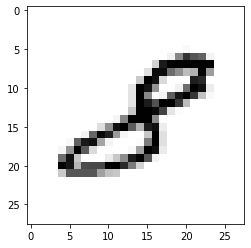

In [350]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data) # 이떄의 linear 은 이미 학습이 끝난 w,b 를 적용한 model
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
